In [4]:
# Some code is shamelessly copied from Learning Blogs
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from pylab import rcParams
import math
import zipfile
from datetime import datetime
from dateutil import parser
import datetime
import random
from functools import reduce
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor


pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 15, 5

def gt(x,y): 
    if x > y:
        return 1
    else:
        return 0
    
def le(x,y): 
    if x <= y:
        return 1
    else:
        return 0


def parseDate(d):
    try:
        return parser.parse(d)        
    except:
        return None

def maxD(v):
    dt1 = parseDate(v[0])
    dt2 = parseDate(v[1])
    if dt1 is not None and dt2 is not None:
        return max(dt1, dt2)
    elif dt1 is not None:
        return dt1
    else:
        return dt2
    
def addDelta(v):
    delta = datetime.timedelta(0,random.randint(1, 15), random.randint(1, 1001))
    dt = parseDate(str(v[0]))
    if dt is not None:
        return dt+delta
    else:
        return dt
    

    
def num(s):
    try:
        return int(s[0])
    except ValueError:
        return float(s[0])
    except ValueError:
        return None

def differ(v):
    d1 = num(v[0])
    d2 = num(v[1])
    if d1 is not None and d2 is not None and abs(d1-d2)<=10:
        return False
    else:
        return True
    
def pererr(err, avg):
    return (err/avg)*100

def mean(l):
    return reduce(lambda x, y: x + y, l) / len(l)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


# invert differenced value
def inverse_difference(history, pred, interval=1):
    return pred + history[-interval]

    
def predict(coef, history):
    pred = 0.0
    for i in range(1, len(coef)+1):
        pred += coef[i-1] * history[-i]
    return pred    

def calculateErrs(test, pred):
    errs = []
    for i in range(len(test)):
        err=pererr(abs(test[i]-pred[i]), test[i])
        errs.append(err)
    rmse = sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    print('Test RMSE: %.3f, MAE:%.3f, Err:%.3f'% (rmse, mae, mean(errs)))
    return errs
    
    
def errorRolls(errs):    
    counters = [np.array([le(x,2), le(x,5), le(x,7), le(x,10), le(x,15), gt(x,15)]) for x in errs]
    total = len(counters)*1.0
    errorRollUp = zip([2, 3, 5, 7, 10, 15, 15], reduce((lambda x,y : x+y), counters))
    return [(x[0], ((x[1]/total)*100)) for x in errorRollUp] 

## CLUB DataFrame Based on TruckTypes
def clubTruckTypes(truck_types_to_club, kpi_groupBy):
    all_groups=[]
    tobe_clubbed={}
    ## Group certain DF based on TruckTypes
    for (x, y) in kpi_groupBy:
        if x[3] in truck_types_to_club:
            key = (x[0], x[1], x[2])
            if tobe_clubbed.get(key):
                tobe_clubbed[key].append(y)
            else:
                tobe_clubbed[key] = [y]
        else:
            all_groups.append((x, y))            
    for (k,v) in tobe_clubbed.iteritems():
        key = k+(truck_types_to_club[0],)
        all_groups.append((key, pd.concat(v)))        
    return all_groups

## Convert DATAFrame to Series with Resampling & Forward/Backword Filling NANs
def getSeriesWithResampleAndFNA(kpi, groupBY, truck_types_to_club, ptr="ptr", date="d", W=8):
    kpi_ = kpi[(pd.isnull(kpi[ptr])==False)]
    kpi_groupBy = kpi_.groupby(groupBY)
    kpi_groupBy = [x for x in list(kpi_groupBy) if len(x[1]) >= W]
    if truck_types_to_club:
        kpi_groupBy =  clubTruckTypes(truck_types_to_club, kpi_groupBy)   
    all_series = [(x[0], Series(x[1][ptr].values, index=x[1][date].values)) for x in kpi_groupBy]
    all_series = [(x, s.sort_index()) for (x, s) in all_series]
    all_series = [(x, s.resample("1d").fillna(method="ffill").fillna(method="bfill")) for (x, s) in all_series]
    return [(x, s) for (x, s) in all_series if len(s) > W]


## Convert DATAFrame to Series without Any Resampling
def getSeriesWithoutResample(kpi, groupBY, truck_types_to_club, ptr="ptr", date="d", W=8):
    kpi_ = kpi[(pd.isnull(kpi[ptr])==False)]
    kpi_groupBy = kpi_.groupby(groupBY)
    if truck_types_to_club:
        kpi_groupBy =  clubTruckTypes(truck_types_to_club, kpi_groupBy)   
    kpi_groupBy = [x for x in list(kpi_groupBy) if len(x[1]) >= W]
    all_series = [(x[0], Series(x[1][ptr].values, index=x[1][date].values)) for x in kpi_groupBy]
    all_series = [(x, s.sort_index()) for (x, s) in all_series]
    return [(x, s) for (x, s) in all_series if len(s) >= W]

## get moving window features from the series for W size window with differencing
def getMovingWindowFeatures(series, W, last=False):
    X = series.values
    # converting time to epoch
    time = [t.to_datetime64().astype(np.int64)//10 ** 9 for t in series.index]
    # move each window(W+2) by 1  data point
    # keep last chunk for prediction
    NWs = len(X)-W-1 

    # Features should have dimensions (NWs x WSize)
    # Labels should have dimensions (NWs)
    feat = np.zeros( [NWs, 2*W] ) - 9999999.
    labl = np.zeros( [NWs] ) - 99999
    delta = [0]*NWs
    
    # Now fill the train feature and label arrays with differencing
    for i in range(NWs):
        feat[i,:] = np.concatenate((time[i:i+W] - time[i+W], X[i:i+W] - X[i+W]))        
        assert np.isfinite(feat[i, :]).all(), (W, len(X), NWs, i, series)
        labl[i]   = X[i+W+1] - X[i+W]    
        delta[i] = X[i+W]

    if last:
        n = len(X)-1
        return (feat, labl, delta, np.concatenate((time[n-W:n] - time[n], X[n-W:n] - X[n])), X[n])
    return (feat, labl, delta)

# get features for all the series with given window size
def getFeaturesForAllSeries(all_series, keys, W=7):
    all_series_features = [(x[0], getMovingWindowFeatures(x[1], W, True)) for x in all_series]
    train_feat, train_labl = [], []
    test_feat, test_delta = [], []
    for (x,(feat,lbl,_,pf,delta)) in all_series_features:
        for (f, l) in zip(feat, lbl):
            train_feat.append(dict(zip (keys, list(x)+f.tolist())))
            train_labl.append(l)
        test_feat.append(dict(zip (keys, list(x)+pf.tolist())))
        test_delta.append(delta)        
    return ((train_feat, train_labl), (test_feat, test_delta))

# get features for all the series with given window size and split into training and testing datasets
def getFeaturesForAllSeriesWithSplit(all_series, keys, W=7, train_frac = 0.5):
    all_series_features = [(x[0], getMovingWindowFeatures(x[1], W)) for x in all_series]    
    train_feat, train_labl = [], []
    test_feat, test_labl = [], []
    test_delta = []    
    for (x,(feat,lbl, delta)) in all_series_features:
        t_size = int(len(feat)*train_frac)    
        for (f, l) in zip(feat[:t_size], lbl[:t_size]):
            train_feat.append(dict(zip (keys, list(x)+f.tolist())))
            train_labl.append(l)
        for (f, l) in zip(feat[t_size:], lbl[t_size:]):
            test_feat.append(dict(zip (keys, list(x)+f.tolist())))
            test_labl.append(l)
        test_delta = test_delta + delta[t_size:]    
    return ((train_feat, train_labl), (test_feat, test_labl, test_delta))

# Transform Features into Vectorize form
def transformFeatures(train_feat, test_feat, vec = DictVectorizer()):
    train_feat_t = vec.fit_transform(train_feat).toarray()
    test_feat_t = vec.transform(test_feat).toarray()
    return (train_feat_t, test_feat_t)

def splitData(all_series_fna, keys, W=7, train_frac = 0.5):
    all_series_fna_featured = [(x[0], toWindowFeatures(x[1], 5)) for x in all_series_fna]    
    train_feat, train_labl = [], []
    test_feat, test_labl = [], []
    test_delta = []    
    for (x,(feat,lbl, delta)) in all_series_fna_featured:
        t_size = int(len(feat)*train_frac)    
        for (f, l) in zip(feat[:t_size], lbl[:t_size]):
            train_feat.append(dict(zip (keys, list(x)+f.tolist())))
            train_labl.append(l)
        for (f, l) in zip(feat[t_size:], lbl[t_size:]):
            test_feat.append(dict(zip (keys, list(x)+f.tolist())))
            test_labl.append(l)
        test_delta = test_delta + delta[t_size:]    
    return ((train_feat, train_labl), (test_feat, test_labl, test_delta))

# Run Improved RFR with given dataframe df, Window Size W and T as in # of predictions to do
def runIRFRForDF(df, groupBY, keys, truck_types_to_club,  W=7, T=1):
    rfr = RandomForestRegressor(n_estimators=100, 
                            criterion='mae', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_leaf_nodes=None, 
                            bootstrap=True, oob_score=False, n_jobs=-1, 
                            random_state=None, verbose=0)
    all_series = getSeriesWithoutResample(df, groupBY, truck_types_to_club)
    ((train_feat, train_labl), (test_feat, delta)) = getFeaturesForAllSeries(all_series, keys)
    # Transform the features
    (train_feat_t, test_feat_t) = transformFeatures(train_feat, test_feat)
    # Learn IRFR
    rfr.fit(train_feat_t, train_labl)
    pred = rfr.predict(test_feat_t)    
    pred_act = []
    for i in range(len(pred)):
        pred_act.append(pred[i]+delta[i])
    return {(":".join([t[k] for k in groupBY])):(p, t) for t,p in zip(test_feat, pred_act)}        

def learnRFR(train_feat_t, train_labl):
    rfRegress = RandomForestRegressor(n_estimators=100, 
                            criterion='mae', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_leaf_nodes=None, 
                            bootstrap=True, oob_score=False, n_jobs=-1, 
                            random_state=None, verbose=0)
    rfRegress.fit(train_feat_t, train_labl)
    return rfRegress

def checkNull(test_feat_t):
    return [e for e in test_feat_t if not np.isfinite(e).all()]


def IRFR(kpi):
    all_series = getSeriesWithResampleAndFNA(kpi)
    ((train_feat, train_labl), (test_feat, delta)) = makeFeaturesAndSplit(all_series)
    (train_feat_t, test_feat_t) = transformFeatures(train_feat, test_feat)
    rfr=learnRFR(train_feat_t, train_labl)
    pred = rfr.predict(test_feat_t)    
    pred_act = []

    for i in range(len(pred)):
        pred_act.append(pred[i]+delta[i])
    return (test_feat, pred_act)

In [5]:
kp = pd.read_csv("data/order-reports_09_10_2017_19_45.csv.zip", header=0)
kpi=kp.iloc[:, 
          [0, 2, 6, 7, 8, 9, 10, 11, 14, 20, 22, 
           37, 38, 39, 75, 41, 93, 95]]
# Picking earliest of Order Accepted or Order Blocked date as Order Date
kpi['date']=kpi[['Order Accepted', 'Order Blocked']].apply(maxD, axis=1)
#kpi.drop(['Order Accepted', 'Order Blocked'], axis=1, inplace=True)
## Checking how much bad Values/Rows we have
kpi[(pd.isnull(kpi['Freight Amount'])==False) & (pd.isnull(kpi['Order Value'])==False)].count()
# droping all rows where we don't know about date (i.e date is null)
kpi = kpi[pd.isnull(kpi['date'])==False]
# calculating per unit km per ton price for the lane
kpi['ptr'] = (kpi['Freight Amount']/kpi['Tonnage'])
# Lets try to make d as unique as possible by adding some secs, ms
kpi['d'] = kpi[['date']].apply(addDelta, axis=1)
kpi['d'].unique().size
kpi=kpi[kpi['d']>= parseDate("08/01/2017")]
kpi['epoch'] =  kpi['d'].astype(np.int64)//10 ** 9 

# should come around the count of rows we have
kpi.count()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Id                     5417
Customer Name          5417
From City              5417
To City                5417
Distance               5415
From Sublocation       5417
To Sublocation         5417
Order Value            4367
Used truck Type        4373
Warehouse Start Loc    5417
Warehouse End Loc      5417
Sector Name            5417
Tonnage                5408
Per Ton Rate           4308
Product Name           5417
Freight Amount         4367
Order Accepted         5350
Order Blocked            86
date                   5417
ptr                    4367
d                      5417
epoch                  5417
dtype: int64

In [6]:
PARAM_TUPS = [
    { "from_sub" : 'Kandla', "to_sub" : 'Pathankot', "truck_name" : '30 MT', "product_type" : 'Coal' },
    { "from_sub" : 'Kandla', "to_sub" : 'Dabok', "truck_name" : '30 MT', "product_type" : 'Coal' },
    { "from_sub" : 'Kandla', "to_sub" : 'Dholka', "truck_name" : '30 MT', "product_type" : 'Coal' },
    { "from_sub" : 'Kandla', "to_sub" : 'Modinagar', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Ghaziabad', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Ludhiana', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Muzaffarnagar', "truck_name" : '34T', "product_type" : 'Coal' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Karnal', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Agra', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Pinglaj', "truck_name" : '27T/28T', "product_type" : 'Sugar' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Rabariyawas', "truck_name" : '30 MT', "product_type" : 'Coal' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Muzaffarnagar', "truck_name" : '34T', "product_type" : 'Petroleum Coke' },
    { "from_sub" : 'Kandla', "to_sub" : 'Rabariyawas', "truck_name" : '34T', "product_type" : 'Coal' },        
    { "from_sub" : 'Kandla', "to_sub" : 'Madhopur', "truck_name" : '30 MT', "product_type" : 'Coal' },        
    { "from_sub" : 'Tuna', "to_sub" : 'Pathankot', "truck_name" : '30 MT', "product_type" : 'Coal' },        
    { "from_sub" : 'Gandhidham', "to_sub" : 'Panipat', "truck_name" : '27T/28T', "product_type" : 'Textiles' },        
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Dholpur House', "truck_name" : '27T/28T', "product_type" : 'Oil' },
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Ambala', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Ghaziabad', "truck_name" : '27T/28T', "product_type" : 'Oil' },        
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Kashmere Gate', "truck_name" : '27T/28T', "product_type" : 'Oil' },
    #########
    { "from_sub" : 'Kandla', "to_sub" : 'Pathankot', "truck_name" : '27T/28T', "product_type" : 'Coal' },
    { "from_sub" : 'Kandla', "to_sub" : 'Madhopur', "truck_name" : '27T/28T', "product_type" : 'Coal' },        
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Agra', "truck_name" : '27T/28T', "product_type" : 'Oil' },
    { "from_sub" : 'Lilashah Nagar', "to_sub" : 'Dholpur House', "truck_name" : '34T', "product_type" : 'Oil' },
    { "from_sub" : 'Anjar', "to_sub" : 'Agra', "truck_name" : '21T/20T', "product_type" : 'Oil' },
]

filterBY = ['From City', 'From Sublocation', 'To City','To Sublocation','Product Name', 'Used truck Type', 'Distance', 'epoch', 'ptr']
groupBY = ['From City', 'From Sublocation', 'To City', 'To Sublocation', 'Product Name', 'Used truck Type']
keys = ['From City', 'From Sublocation', 'To City', 'To Sublocation', 'Product Name', 'Used truck Type', 
        'd1', 'd2', 'd3', 'pd1', 'pd2', 'pd3']
truck_types_to_club = ['27T/28T', '30 MT','34T']

In [7]:
# check whether we have duplicate dates
print kpi['date'].unique().size
# how many duplicates we have
kpi[kpi.date.duplicated()].count()


4575


Id                     842
Customer Name          842
From City              842
To City                842
Distance               842
From Sublocation       842
To Sublocation         842
Order Value            701
Used truck Type        701
Warehouse Start Loc    842
Warehouse End Loc      842
Sector Name            842
Tonnage                842
Per Ton Rate           700
Product Name           842
Freight Amount         701
Order Accepted         841
Order Blocked            2
date                   842
ptr                    701
d                      842
epoch                  842
dtype: int64

In [8]:
all_series = getSeriesWithoutResample(kpi, groupBY, truck_types_to_club, W=3)

In [9]:
all_series

[(('Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T'),
  2017-08-12 12:15:05.000345    3220.0
  2017-08-17 07:20:12.000748    2920.0
  2017-09-20 10:26:10.000246    2920.0
  2017-09-22 17:43:08.000002    3120.0
  dtype: float64),
 (('Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '27T/28T'),
  2017-08-04 21:36:09.000318    2800.0
  2017-08-13 14:14:02.000556    2700.0
  2017-09-24 11:01:15.000093    2600.0
  2017-09-27 12:15:14.000108    2600.0
  dtype: float64),
 (('Anjar', 'Anjar', 'Chittorgarh', 'Shambhupura', 'Petroleum Coke', '30 MT'),
  2017-09-25 08:57:05.000338    1265.0
  2017-09-25 10:09:13.000365    1265.0
  2017-09-25 10:56:15.000413    1265.0
  2017-09-25 15:29:10.000250    1265.0
  2017-09-25 16:21:07.000891    1265.0
  dtype: float64),
 (('Anjar', 'Anjar', 'Chittorgarh', 'Shambhupura', 'Petroleum Coke', '34T'),
  2017-09-25 08:55:03.000466    1265.0
  2017-09-25 08:55:15.000868    1265.0
  2017-09-28 03:43:12.000168    1370.0
  dtype: float64),
 (('Anjar', 'Anjar', 'Ghaziabad'

In [10]:
kpi_ = kpi[(pd.isnull(kpi['ptr'])==False) &(pd.isnull(kpi['Distance'])==False)& (pd.isnull(kpi['epoch'])==False)]
kpi_groupBy = kpi_.groupby(groupBY)
kpi_groupBy = [x for x in list(kpi_groupBy)]
kpi_groupBy = [x[1][filterBY].sort_values(['epoch']).values for x in kpi_groupBy]
kpi_groupBy

[array([['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1079368.0,
         1502540105, 3220.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1079368.0,
         1502954412, 2920.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1086030.0,
         1505903170, 2920.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1085939.0,
         1506102188, 3120.0]], dtype=object),
 array([['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '27T/28T', 1079368.0,
         1501882569, 2800.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '27T/28T', 1079368.0,
         1502633642, 2700.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '27T/28T', 1083181.0,
         1506250875, 2600.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '27T/28T', 1083181.0,
         1506514514, 2600.0]], dtype=object),
 array([['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', 'Unknown', 1086031.0,
         1505837941, 3000.0],
        ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', 

In [11]:
train=[x for x in kpi_groupBy if len(x)>1]
test=[x for x in kpi_groupBy if len(x)==1]

In [23]:
train[0]

array([['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1079368.0,
        1502540105, 3220.0],
       ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1079368.0,
        1502954412, 2920.0],
       ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1086030.0,
        1505903170, 2920.0],
       ['Anjar', 'Anjar', 'Agra', 'Agra', 'Oil', '21T/20T', 1085939.0,
        1506102188, 3120.0]], dtype=object)

In [12]:
filterBY = ['From City', 'From Sublocation', 'To City','To Sublocation','Product Name', 'Used truck Type', 'Distance', 'epoch', 'ptr']
train_feat=[]
train_lbl=[]
test_feat=[]
test_lbl=[]
for t in train:
    for e in t:
        train_feat.append(dict(zip(filterBY[:-1], e[:-1])))
        train_lbl.append(e[-1])
        
for t in test:
    for e in t:
        test_feat.append(dict(zip(filterBY[:-1], e[:-1])))
        test_lbl.append(e[-1])

print len(train_lbl), len(test_lbl)

4185 180


In [24]:
train_lbl

[3220.0,
 2920.0,
 2920.0,
 3120.0,
 2800.0,
 2700.0,
 2600.0,
 2600.0,
 3000.0,
 2600.0,
 820.0,
 820.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 1370.0,
 2750.0,
 2750.0,
 2770.0,
 2770.0,
 920.0,
 2770.0,
 2770.0,
 2770.0,
 2770.0,
 2770.0,
 2770.0,
 2770.0,
 1350.0,
 1350.0,
 1350.0,
 1350.0,
 1360.0,
 1360.0000000000002,
 1350.0,
 2600.0,
 2600.0,
 2620.0,
 2620.0,
 2620.0,
 2620.0,
 2800.0,
 2780.0,
 2850.0,
 2800.0,
 2810.0,
 2880.0,
 2880.0,
 2800.0,
 2800.0,
 2850.0,
 900.0,
 900.0,
 900.0,
 850.0,
 900.0,
 900.0,
 900.0,
 900.0,
 2770.0,
 2770.0,
 2649.9999999999995,
 2600.0,
 2600.0000000000005,
 3000.0,
 3000.0,
 2600.0,
 3000.0,
 3000.0,
 3000.0,
 3000.0,
 3000.0,
 3000.0,
 2819.9999999999995,
 2820.0,
 2870.0,
 3036.0,
 3382.3529411764707,
 3407.4074074074074,
 3020.0,
 3020.0,
 2770.0,
 2820.0,
 2800.0,
 2750.0,
 2750.0,
 2750.0,
 2750.0,
 2750.0,
 2700.0,
 2700.0,
 2750.0,
 2750.0,
 2750.0,
 2750.0,
 2700.0,
 2700.0,
 2750.0,
 2750.0,
 2840.0,
 28

In [15]:
vec=DictVectorizer()
(train_feat_t, test_feat_t) = transformFeatures(train_feat, test_feat, vec)

In [18]:
train_feat_t[0]

array([1.0793680e+06, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [16]:
def learnRFR(train_feat_t, train_labl):
    rfRegress = RandomForestRegressor(n_estimators=100, 
                            criterion='mae', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_leaf_nodes=None, 
                            bootstrap=True, oob_score=False, n_jobs=-1, 
                            random_state=None, verbose=0)
    rfRegress.fit(train_feat_t, train_labl)
    return rfRegress

rfr=learnRFR(train_feat_t, train_lbl)


In [182]:
pred=rfr.predict(test_feat_t)

In [196]:
errs=[]
for i in range(len(pred)):
    errs.append(abs(100*((pred[i]-test_lbl[i])/(1.0*test_lbl[i]))))
    print "F=%r, Actual=%0.2f, P=%0.2f, Err=%0.2f\n" %(test_feat[i], test_lbl[i], pred[i], errs[i])
    
    
    

F={'Distance': 1321695.0, 'To Sublocation': 'Ambala', 'To City': 'Ambala', 'From City': 'Anjar', 'epoch': 1506263461, 'Used truck Type': '30 MT', 'Product Name': 'Coal', 'From Sublocation': 'Anjar'}, Actual=2700.00, P=2715.60, Err=0.58

F={'Distance': 1321785.0, 'To Sublocation': 'Ambala', 'To City': 'Ambala', 'From City': 'Anjar', 'epoch': 1505398982, 'Used truck Type': '34T', 'Product Name': 'Coal', 'From Sublocation': 'Anjar'}, Actual=2600.00, P=2685.30, Err=3.28

F={'Distance': 1310042.0, 'To Sublocation': 'Amritsar', 'To City': 'Amritsar', 'From City': 'Anjar', 'epoch': 1503840433, 'Used truck Type': '27T/28T', 'Product Name': 'Oil', 'From Sublocation': 'Anjar'}, Actual=2550.00, P=2696.20, Err=5.73

F={'Distance': 1373450.0, 'To Sublocation': 'Jalandhar', 'To City': 'Jalandhar', 'From City': 'Anjar', 'epoch': 1505822652, 'Used truck Type': '27T/28T', 'Product Name': 'Oil', 'From Sublocation': 'Anjar'}, Actual=2850.00, P=2821.20, Err=1.01

F={'Distance': 1316942.0, 'To Sublocation'

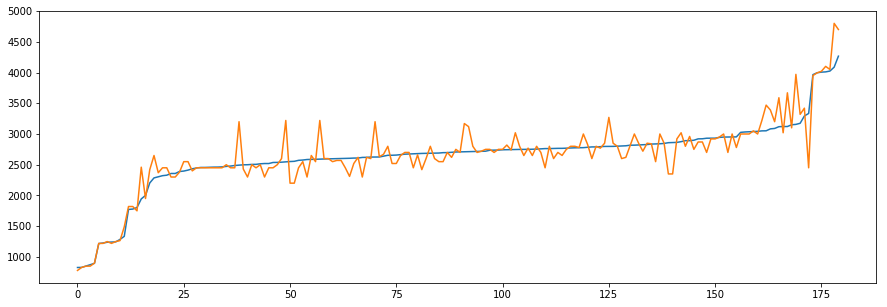

In [198]:
sorted_=zip(pred, test_lbl)

sorted_.sort()
plt.plot(sorted_)

(array([ 83.,  32.,  17.,  10.,   7.,   6.,   4.,   7.,   5.,   1.,   1.,
          4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.14503817e-02,   1.81462737e+00,   3.61780437e+00,
          5.42098136e+00,   7.22415835e+00,   9.02733534e+00,
          1.08305123e+01,   1.26336893e+01,   1.44368663e+01,
          1.62400433e+01,   1.80432203e+01,   1.98463973e+01,
          2.16495743e+01,   2.34527513e+01,   2.52559283e+01,
          2.70591053e+01,   2.88622823e+01,   3.06654593e+01,
          3.24686362e+01,   3.42718132e+01,   3.60749902e+01]),
 <a list of 20 Patch objects>)

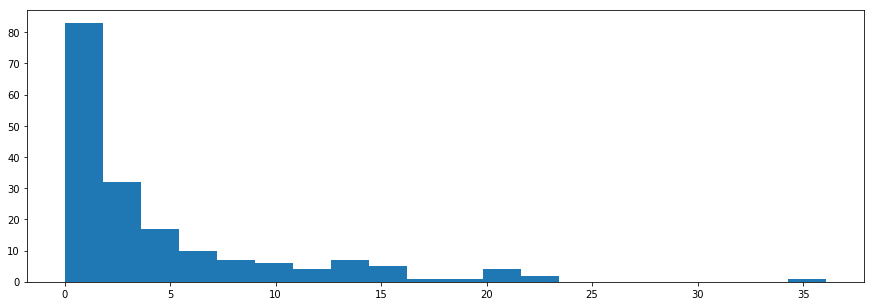

In [203]:
errs.sort()
plt.hist(errs, bins=20)

In [ ]:
all_series = getSeriesWithResampleAndFNA(kpi)
((train_feat, train_labl),(test_feat, test_labl, delta)) = splitData(all_series, 0.7)
(train_feat_t, test_feat_t) = transformFeatures(train_feat, test_feat)
rfr=learnRFR(train_feat_t, train_labl)
pred = rfr.predict(test_feat_t)    
plt.plot(test_labl, "b-")
plt.plot(pred,'g-')

Test RMSE: 51.378, MAE:12.857
Test RMSE: 51.378, MAE:12.857, Err:0.456


[(2, 92.903800475059384),
 (3, 97.149643705463191),
 (5, 98.723277909738712),
 (7, 99.376484560570063),
 (10, 99.762470308788593),
 (15, 0.23752969121140144)]

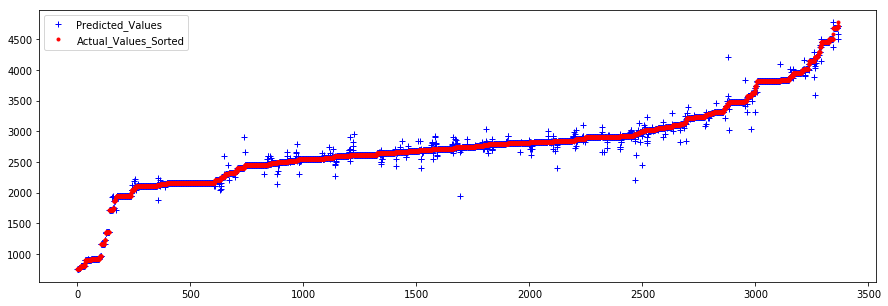

In [162]:
rmse = sqrt(mean_squared_error(pred, test_labl))
mae = mean_absolute_error(pred, test_labl)
print('Test RMSE: %.3f, MAE:%.3f'% (rmse, mae))
pred_act = []
test_act = []
for i in range(len(pred)):
    pred_act.append(pred[i]+delta[i])
    test_act.append(test_labl[i]+delta[i])
    
sorted_zips = sorted(zip(test_act, pred_act))
x1 = [x[0] for x in sorted_zips]
x2 = [x[1] for x in sorted_zips]
plt.plot(x2, "b+", label="Predicted_Values")
plt.plot(x1, "r.", label="Actual_Values_Sorted")
plt.legend()    
errs = calculateErrs(test_act, pred_act)
errs_ = [e for e in errs if e < 100]
errorRolls(errs)

4735
4735
114
114
4735


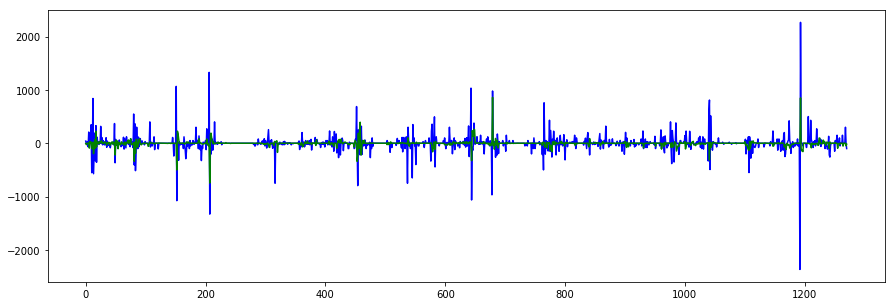

In [163]:
all_series = getDataWithoutResample(kpi)
((train_feat, train_labl),(test_feat, test_labl, delta)) = splitData(all_series, 0.7)
(train_feat_t, test_feat_t) = transformFeatures(train_feat, test_feat)
rfr=learnRFR(train_feat_t, train_labl)
pred = rfr.predict(test_feat_t)    
plt.plot(test_labl, "b-")
plt.plot(pred,'g-')

Test RMSE: 158.868, MAE:65.797
Test RMSE: 158.868, MAE:65.797, Err:6.066


[(2, 67.112509834775764),
 (3, 86.546026750590087),
 (5, 90.401258851298195),
 (7, 93.784421715184891),
 (10, 96.616837136113304),
 (15, 3.3831628638867031)]

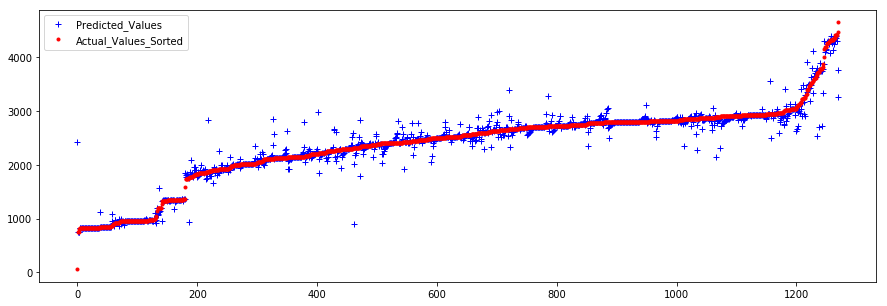

In [165]:
rmse = sqrt(mean_squared_error(pred, test_labl))
mae = mean_absolute_error(pred, test_labl)
print('Test RMSE: %.3f, MAE:%.3f'% (rmse, mae))
pred_act = []
test_act = []
for i in range(len(pred)):
    pred_act.append(pred[i]+delta[i])
    test_act.append(test_labl[i]+delta[i])
    
sorted_zips = sorted(zip(test_act, pred_act))
x1 = [x[0] for x in sorted_zips]
x2 = [x[1] for x in sorted_zips]
plt.plot(x2, "b+", label="Predicted_Values")
plt.plot(x1, "r.", label="Actual_Values_Sorted")
plt.legend()    
errs = calculateErrs(test_act, pred_act)
errs_ = [e for e in errs if e < 100]
errorRolls(errs)